With invariant mapping and injection pattern, when NoC is in congestion, we wanna see if the performance is relevant to injection rate.

In [5]:
sys.path.append("..")

import os
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import global_control as gc
from focus_agent.sampler import LayerSampler, LayerSample
from focus_agent.focus_agent import FocusAgent
from trace_parser.trace_parser import TraceParser
from graph_generator.hyper import HyperGraphGenerator


In [6]:
random_sample = True
# you can customize a sample here, or use a random sample.

if random_sample is True:
    sampler = LayerSampler(seed=1919810)
    sample = sampler.get_random_sample()

    # minimize delay to 1
    delay_tags =  ['delay_w', 'delay_i', 'delay_o']
    min_delay = min([sample.params['delay_w'], sample.params['delay_i'], sample.params['delay_o']])
    for d in delay_tags:
        sample.params[d] = sample.params[d] // min_delay

    print(sample)

else:
    sample = LayerSample({
        'cnt_w': 64,
        'cnt_i': 64,
        'cnt_o': 64,
        'flit_w': 2,
        'flit_i': 4,
        'flit_o': 8,
        'delay_w': 1,
        'delay_i': 2,
        'delay_o': 1,
        'broadcast_w': 0,
        'broadcast_i': 1,
        'worker': 8,
    })

cw64_ci64_co64_bw0_bi1_fw4_fi2_fo10_dw1_di1_do1_n13


In [22]:
# run simulation
agent = FocusAgent(fake_trace=True, simulate=True)
task_root = os.path.join(gc.dataset_root, "scripts", "throuput")
if not os.path.exists(task_root):
    os.mkdir(task_root)

# let's try exponential delay increment first
factors = [1, 2, 4, 8, 16, 32, 64, 128, 256, 300, 400, 500, 600, 700, 800, 900, 1024]
for factor in tqdm(factors):
    sample_ = copy.deepcopy(sample)
    for d in delay_tags:
        sample_.params[d] *= factor

    sample_.dump(task_root, "model")
    benchmark_path = os.path.join(task_root, "model.yaml")
    try:
        agent.run_focus(benchmark_path, 8, 1024, timeout=300, verbose=False)
    except TimeoutError:
        print(f"Simulating factor={factor} timeout")


100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


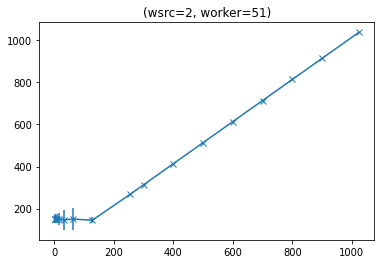

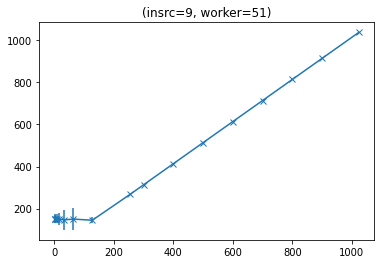

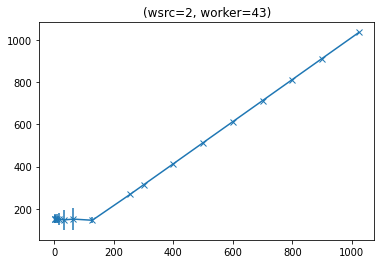

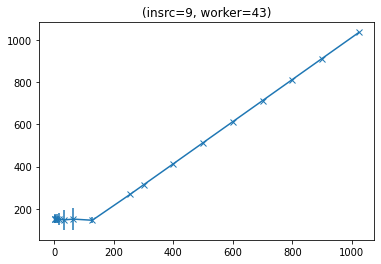

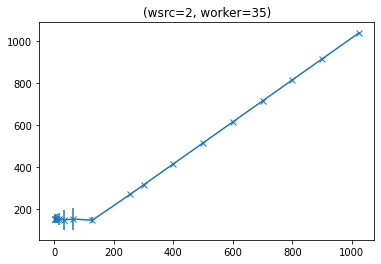

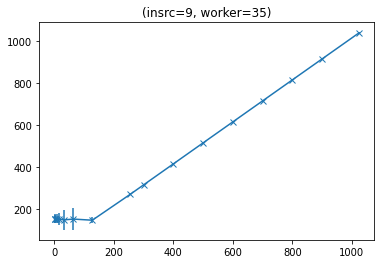

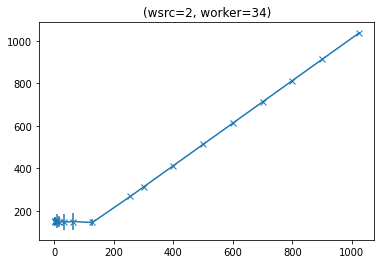

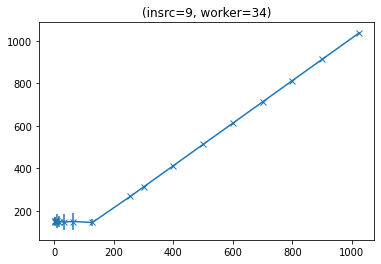

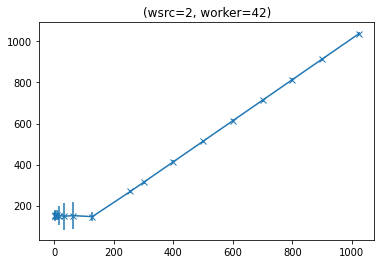

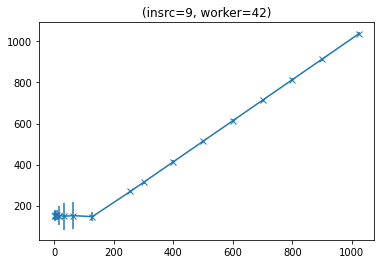

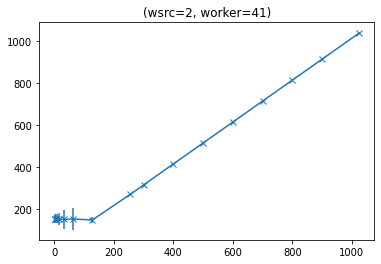

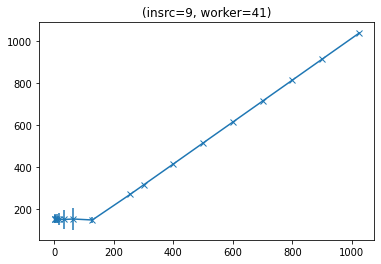

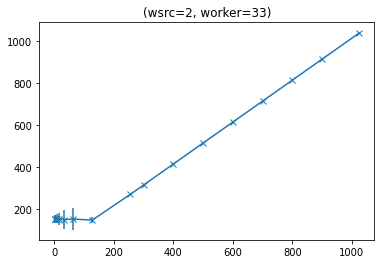

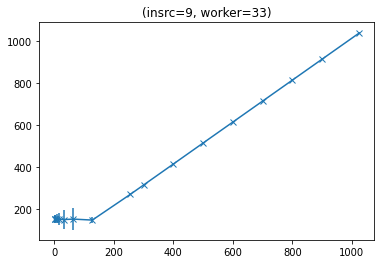

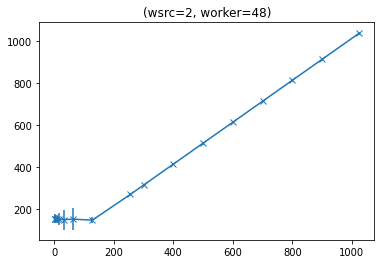

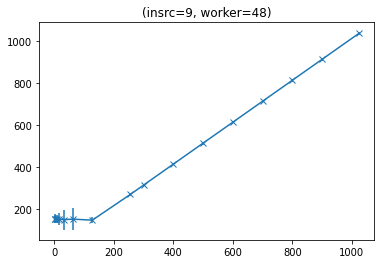

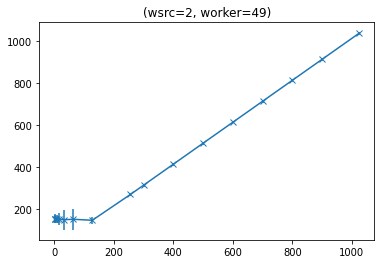

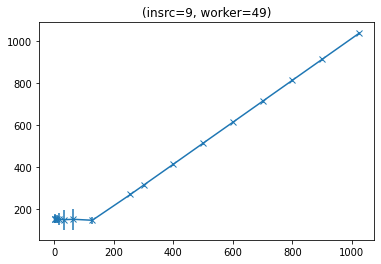

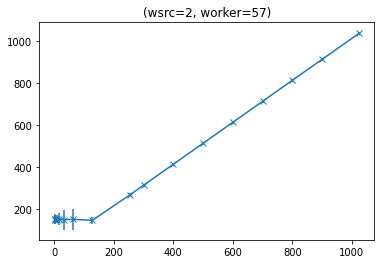

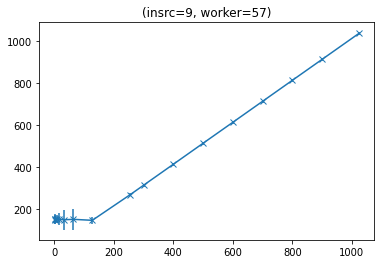

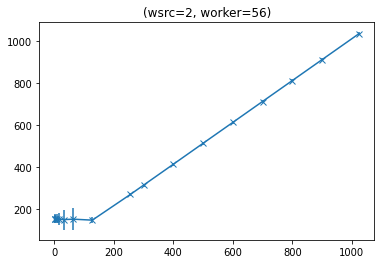

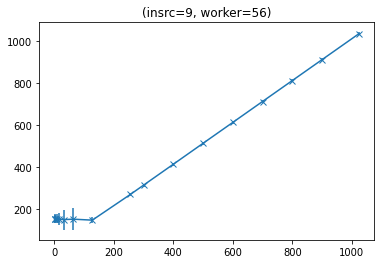

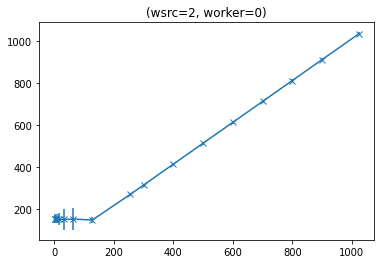

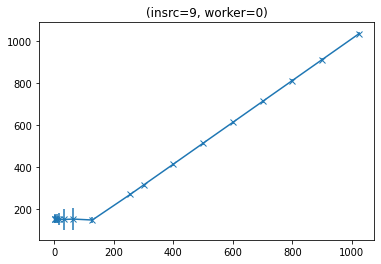

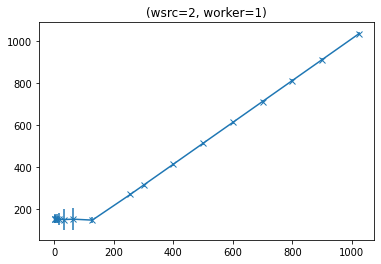

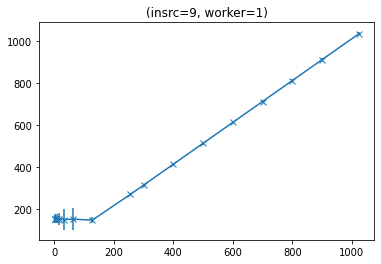

In [23]:
# check packet arrival interval (which approximately is throughput)

end_interval_mean = dict()
end_interval_std = dict()

for factor in factors:
    sample_ = copy.deepcopy(sample)
    for d in delay_tags:
        sample_.params[d] *= factor

    # parse results
    taskname = str(sample_) + f"_b1w1024_8x8"
    trace_parser = TraceParser(
        agent.get_op_graph_path(taskname),
        agent.get_outlog_path(taskname),
        agent.get_routing_path(taskname),
        agent.get_spec_path(taskname),
    )
    G = trace_parser.graph_parser.get_graph()

    # analyze packet arrival time interval
    srcs = [n for n, op_type in G.nodes(data="op_type")
                if op_type == 'wsrc' or op_type == 'insrc']
    workers  = [n for n, op_type in G.nodes(data="op_type")
            if op_type == 'worker']
    sinks = [n for n, op_type in G.nodes(data="op_type") if op_type == "sink"]
    node2pe = lambda x: G.nodes[x]["p_pe"]
    p = trace_parser.outlog_parser

    for w in workers:
        cnt = G.nodes[w]['cnt']
        delay = G.nodes[w]['delay']
        wid = node2pe(w)

        # src to worker edge
        for s in srcs:
            src_type = G.nodes[s]['op_type']
            sid = node2pe(s)
            pid2lat = lambda pid: p.get_latency(sid, wid, pid)["end_cycle"]
            end_cycles = np.array([pid2lat(pid) for pid in G.edges[s, w]['pkt']])
            end_interval = np.diff(end_cycles)

            edge_name = f"({src_type}={sid}, worker={wid})"
            try:
                end_interval_mean[edge_name].append(np.mean(end_interval))
            except:
                end_interval_mean[edge_name] = [np.mean(end_interval)]
            try:
                end_interval_std[edge_name].append(np.std(end_interval))
            except:
                end_interval_std[edge_name] = [np.std(end_interval)]

        # not very useful
        # worker = dst
        # for s in sinks:
        #     sid = node2pe(s)
        #     pid2lat = lambda pid: p.get_latency(wid, sid, pid)["end_cycle"]
        #     end_cycles = np.array([pid2lat(pid) for pid in G.edges[w, s]['pkt']])
        #     end_interval = np.diff(end_cycles)

        #     edge_name = f"(worker={wid}, sink={sid})"
        #     try:
        #         end_interval_mean[edge_name].append(np.mean(end_interval))
        #     except:
        #         end_interval_mean[edge_name] = [np.mean(end_interval)]
        #     try:
        #         end_interval_std[edge_name].append(np.std(end_interval))
        #     except:
        #         end_interval_std[edge_name] = [np.std(end_interval)]


for k in end_interval_mean.keys():
    means = end_interval_mean[k]
    stds = end_interval_std[k]

    plt.title(k)
    plt.errorbar(x=factors, y=means, yerr=stds, marker='x')
    plt.show()